In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
    
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wsxm_read import *
from wsxm_analyze import *

dict_keys(['Excitation frequency', 'Phase'])
dict_keys(['approach', 'retract'])


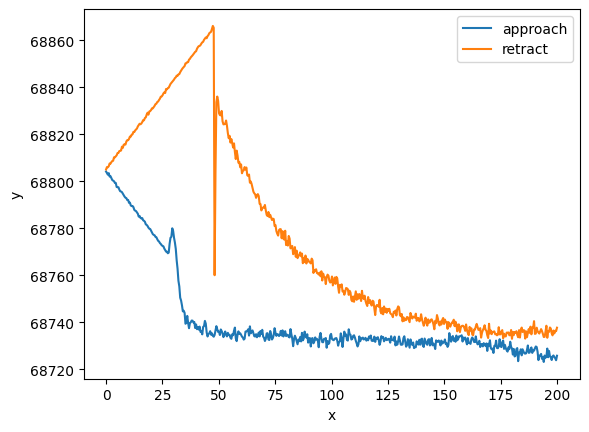

In [2]:
filepath = 'data/interdigThiols_tipSi3nN_b_0023_Excitation frequency.f.curves'
# filepath = 'data/interdigThiolsHeated_tipNweSi3nN_a_0031_Excitation frequency.f.stp'
test_data = wsxm_readcurves(filepath)
print(test_data.keys())
test_chan = 'Excitation frequency' #'Normal force', 'Amplitude', 'Excitation frequency', 'Phase'
curv_num = 1
print(test_data[test_chan]['curves'][curv_num]['data'].keys())

spectro_data = test_data[test_chan]['curves'][curv_num]['data']
test_spectro, test_param = wsxm_calcspectroparam(spectro_data, test_chan)
# print(test_param)
fig, ax = plt.subplots()
sns.lineplot(data=test_spectro, x="x", y="y", hue="segment", ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels) #remove legend title

#show calculations in plot for checking
# plt.hlines(test_param['Adhesion']['zero'], test_spectro['x'].min(), 
#            test_spectro['x'].max(), linestyles='dashed', colors='r')
# plt.hlines(test_param['Adhesion']['min'], test_spectro['x'].min(), 
#            test_spectro['x'].max(), linestyles='dashed', colors='r')
# plt.plot(test_param['Snap-in distance']['x'], test_param['Snap-in distance']['y'],
#          'r', linestyle='solid',linewidth=2)
# plt.plot(test_param['Stiffness']['x'], test_param['Stiffness']['y'],
#          'r', linestyle='solid',linewidth=2)

plt.show()
# test_data[test_chan]['curves'][curv_num]['header']
# print(test_spectro.max())
# test_spectro

['data/interdigThiols_tipSi3nN_b_0030.b.dy.top', 'data/interdigThiols_tipSi3nN_b_0030.f.dy.ch1', 'data/interdigThiols_tipSi3nN_b_0030.b.dy.ch12', 'data/interdigThiols_tipSi3nN_b_0030.f.dy.ch15', 'data/interdigThiols_tipSi3nN_b_0030.b.dy.ch15', 'data/interdigThiols_tipSi3nN_b_0030.f.dy.ch12', 'data/interdigThiols_tipSi3nN_b_0030.b.dy.ch1', 'data/interdigThiols_tipSi3nN_b_0030.f.dy.top']


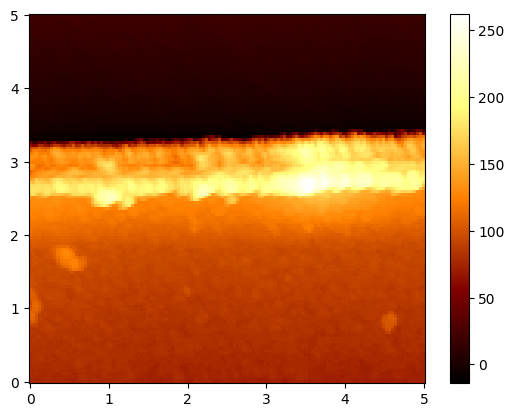

-14.062525423728813 262.5004745762712


In [3]:
filepath = 'data/interdigThiols_tipSi3nN_b_0030.b.dy.top'
test_data = wsxm_readchan(filepath)
test_chan = 'Topography'#'Topography', 'Normal force', 'Excitation frequency', 'Amplitude'
test_dir = 'Backward'
im_data_test = test_data[test_chan][test_dir]
# xx = im_data_test['X'].reshape(128,128)
# yy = im_data_test['Y'].reshape(128,128)
# zz = im_data_test['Z'].reshape(128,128)
xx, yy, zz = get_imgdata(im_data_test)
plt.pcolormesh(xx,yy,zz, cmap='afmhot')
plt.colorbar()
plt.show()
print(zz.min(), zz.max())
# test_data[test_chan][test_dir]['header']

In [2]:
#Load WSxM file
#filepath = 'data/20240202_laser_off_128pts_58lps_0002.f.dy.ch15'
#filepath = 'data/interdigThiols_tipSi3nN_b_0026.f.dy.top'
filepath = 'data/interdigThiols_tipSi3nN_b_0026.fb.ch1.gsi' #ff,fb,bb,bf:1st letter=x dir,2nd letter=z dir
#filepath = 'data/interdigThiols_tipSi3nN_b_0023_Excitation frequency.f.curves'

data_dict = wsxm_readforcevol(filepath) #complete force volume data with all channels

-65.82043713017751 198.24256286982248 264.063


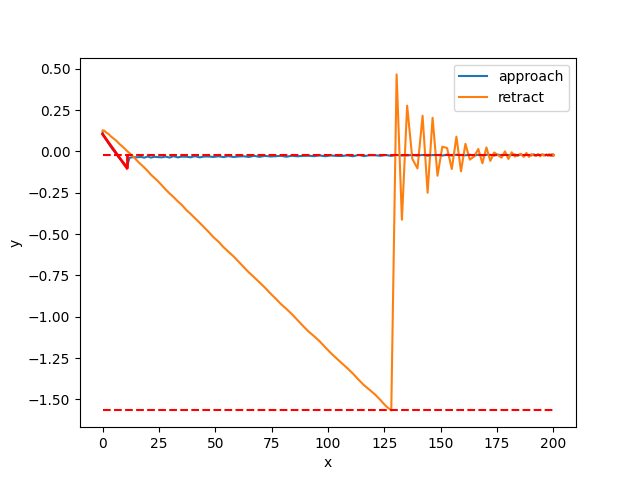

TypeError: descriptor 'remove' for 'list' objects doesn't apply to a 'str' object

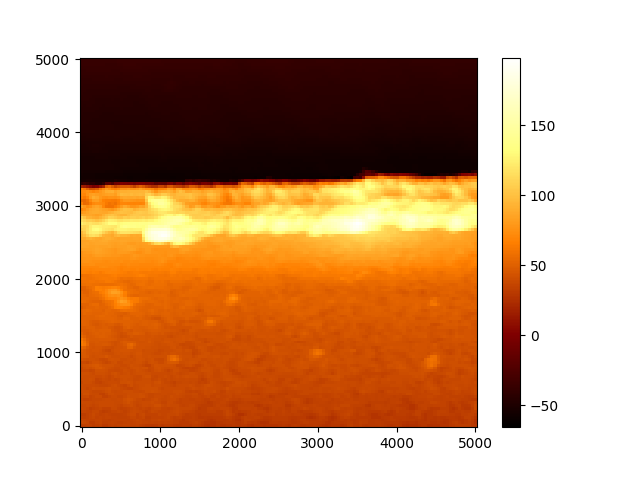

In [7]:
channel = 'Topography' #'Excitation frequency', 'Normal force', 'Amplitude', 'Topography'
chan_dir = 'Image Forward with Backward Ramps' #'Image Forward with Forward Ramps', 'Image Backward with Backward Ramps', 'Image Backward with Forward Ramps', 'Image Forward with Backward Ramps'
img_dir = chan_dir.split(' ')[1]
data_dict_chan = data_dict[channel][chan_dir]
# im_data = data_dict_chan['data']
header_dict = data_dict_chan['header']
x_num = int(header_dict['Number of rows'])
y_num = int(header_dict['Number of rows'])
chan_list = data_dict.keys()

pt_x, pt_y, pt_z = 1, 120, 0
style = 'XY'

# test_data = wsxm_readcurves(filepath)
#plot AFM Z image
# im_data = test_data['Channel']['data']
xx, yy, zz = get_imgdata(data_dict_chan, style, pt_x, pt_y, pt_z) #im_data['X'].reshape(128,128)
# yy = im_data['Y'].reshape(128,128)
# zz = data_dict_chan['data']['Z'] #im_data['Z'].reshape(128,128)
# zz = data_dict_chan['data']['ZZ'][pt_z,:,:]#1st index:xy sections, 2nd index:xz sections, 3rd index: yz sections

#TODO: change and check how forward backward in z (or x) can be consistently plotted
print(zz.min(),zz.max(), zz.max()-zz.min())
plt.figure()
plt.pcolormesh(xx,yy,zz, cmap='afmhot')
plt.colorbar()

# if header_dict['Spectroscopy direction'] == 'Forward': #CHECK THIS
#     segment
#obtain and plot spectroscopy data
chan_spectro = 'Normal force'
# spec_params = ['Adhesion', 'Snap-in distance', 'Stiffness'] #check keys of FUNC_DICT
#CHECK x and y in all functions!!!
spectro_data = wsxm_getspectro(data_dict, channel=chan_spectro,
                               img_dir=img_dir, x=pt_x, y=pt_y)
df_spectro, data_param = wsxm_calcspectroparam(spectro_data, chan_spectro)

# print(fd)
fig, ax = plt.subplots()
sns.lineplot(data=df_spectro, x="x", y="y", hue="segment", ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels) #remove legend title

#show calculations in plot for checking
plt.hlines(data_param['Adhesion']['zero'], df_spectro['x'].min(), 
           df_spectro['x'].max(), linestyles='dashed', colors='r')
plt.hlines(data_param['Adhesion']['min'], df_spectro['x'].min(), 
           df_spectro['x'].max(), linestyles='dashed', colors='r')
plt.plot(data_param['Snap-in distance']['x'], data_param['Snap-in distance']['y'],
         'r', linestyle='solid',linewidth=2)
plt.plot(data_param['Stiffness']['x'], data_param['Stiffness']['y'],
         'r', linestyle='solid',linewidth=2)
# acq_pt = test_data['Curves'][3]['header']['Acquisition point'].strip('()').split(',')
# plt.scatter(float(acq_pt[0]), float(acq_pt[1]),color = 'green')
plt.show()
# header_dict
# #plot Curves
# test_df = pd.DataFrame.from_dict(test_data['Curves'][3]['data'])
# sns.lineplot(data=test_df, x="Z", y="Excitation frequency", hue="Segment")
# plt.show()

# spec_params = ['Adhesion', 'Snap-in distance', 'Stiffness'] #check keys of FUNC_DICT
img_specparams = calc_spectro_prop(data_dict, chan_spectro, img_dir)
img_adh = img_specparams['Snap-in distance']
plt.pcolormesh(xx,yy,img_adh, cmap='afmhot',vmin=None, vmax=0.08)
plt.colorbar()
#plot histogram of parameter
plt.figure()
sns.histplot(img_adh.flatten(),binrange=(0,0.08))
plt.show()
# header_dict

Output()

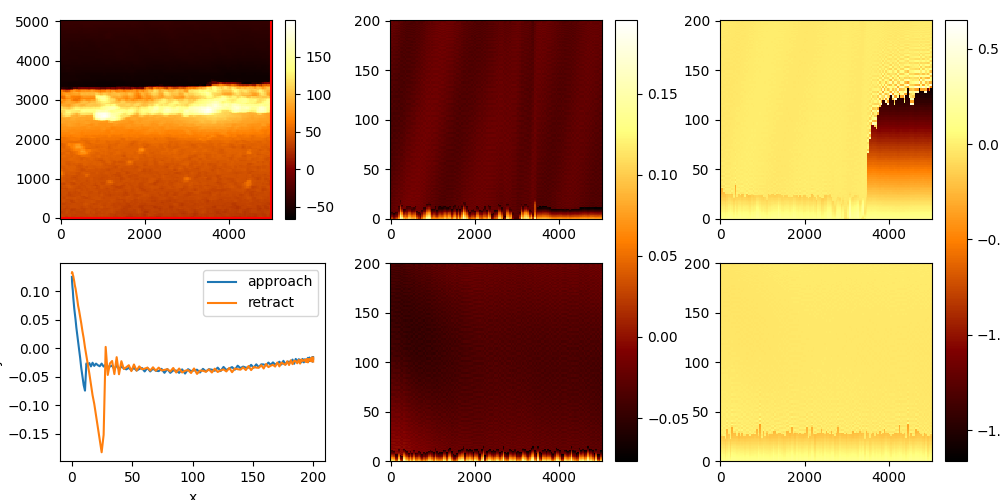

In [13]:
plt.close()
fig, ax = plt.subplots(2,3, figsize=(10,5))
fig.canvas.header_visible = False
fig.canvas.toolbar_position = 'bottom'

channel = 'Normal force' #'Excitation frequency', 'Normal force', 'Amplitude', 'Topography'
# chan_dir = 'Image Forward with Backward Ramps' #'Image Forward with Forward Ramps', 'Image Backward with Backward Ramps', 'Image Backward with Forward Ramps', 'Image Forward with Backward Ramps'
img_dir = 'Forward' #chan_dir.split(' ')[1]
# data_dict_chan = data_dict[channel][chan_dir]
# im_data = data_dict_chan['data']
param_data_dict = calc_spectro_prop(data_dict, channel, img_dir)

header_dict = data_dict['Topography'][f'Image {img_dir} with Forward Ramps']['header']
x_num = int(header_dict['Number of rows'])
y_num = int(header_dict['Number of rows'])
x_data = data_dict['Topography'][f'Image {img_dir} with Forward Ramps']['data']['X']
y_data = data_dict['Topography'][f'Image {img_dir} with Forward Ramps']['data']['Y']
chan_list = list(data_dict.keys())
chan_list.remove('Topography') #only include 3d data in channel list
param_list = list(param_data_dict.keys()) #all calculated parameter images eg. adhesion
param_list.insert(0,'Topography')

zz_mins, zz_maxs = {'approach':[], 'retract':[]}, {'approach':[], 'retract':[]}
for dir_i in data_dict[channel].keys():
    spec_dir_i = SPECT_DICT[dir_i.split(' ')[-2]]
    # print(spec_dir_i, dir_i)
    zz_mins[spec_dir_i].append(data_dict[channel][dir_i]['data']['ZZ'].min())
    zz_maxs[spec_dir_i].append(data_dict[channel][dir_i]['data']['ZZ'].max())
zz_min_a, zz_max_a = min(zz_mins['approach']), max(zz_maxs['approach'])
zz_min_r, zz_max_r = min(zz_mins['retract']), max(zz_maxs['retract'])

#topography
xx, yy, zz = get_imgdata(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'])
pmesh_top = ax[0][0].pcolormesh(xx,yy,zz, cmap='afmhot')
cb_top = plt.colorbar(pmesh_top, ax=ax[0][0])
#XZ section images
xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], 'XZ')
# print(zz.min(), zz.max())
pmesh_xz_a = ax[1][1].pcolormesh(xx,yy,zz, cmap='afmhot') #approach
xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], 'XZ')
pmesh_xz_r = ax[1][2].pcolormesh(xx,yy,zz, cmap='afmhot',vmin=zz_min_r, vmax=zz_max_r) #retract
#YZ section images
xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], 'YZ')
# print(zz.min(), zz.max())
pmesh_yz_a = ax[0][1].pcolormesh(xx,yy,zz, cmap='afmhot') #approach
xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], 'YZ')
pmesh_yz_r = ax[0][2].pcolormesh(xx,yy,zz, cmap='afmhot',vmin=zz_min_r, vmax=zz_max_r) #retract

plt.tight_layout()
plt.colorbar(pmesh_xz_a, ax=[ax[0][1], ax[1][1]])
plt.colorbar(pmesh_xz_r, ax=[ax[0][2], ax[1][2]])

#spectroscopy
spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir)
df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
line_spec = sns.lineplot(data=df_spectro, x="x", y="y", hue="segment", ax=ax[1][0])
handles, labels = ax[1][0].get_legend_handles_labels()
ax[1][0].legend(handles=handles, labels=labels)
#position lines on topo
line_h = ax[0][0].axhline(y_data[0], x_data[0], x_data[-1], linestyle='solid', color='r')
line_v = ax[0][0].axvline(x_data[0], y_data[0], y_data[-1], linestyle='solid', color='r')

#widgets
slide_x = widgets.IntSlider(value=0, min=0, max=x_num-1, step=1,
                            description='x',continuous_update=False)
slide_y = widgets.IntSlider(value=0, min=0, max=y_num-1, step=1,
                            description='y',continuous_update=False)
chan_button = widgets.ToggleButtons(options=chan_list,
                                    # description='Channel:',
                                     disabled=False)
imgdir_button = widgets.ToggleButtons(options=['Forward', 'Backward'],
                                    # description='Channel:',
                                     disabled=False)
param_dropdown = widgets.Dropdown(options=param_list,
                                  value='Topography',disabled=False)
output = widgets.Output()
box1 = widgets.VBox([slide_x, slide_y])
box2 = widgets.VBox([param_dropdown, imgdir_button])
box3 = widgets.VBox([chan_button])

# @output.capture()
def update_x(change):
    # line.set_ydata(np.sin(change.new * x))
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], 'YZ', x=change.new) 
    pmesh_yz_a.set_array(zz)
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], 'YZ', x=change.new)
    pmesh_yz_r.set_array(zz)
    spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=change.new, y= slide_y.value)
    df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
    ax[1][0].get_legend().remove()
    ax[1][0].clear()
    sns.lineplot(data=df_spectro, x="x", y="y", hue="segment", ax=ax[1][0])
    handles, labels = ax[1][0].get_legend_handles_labels()
    ax[1][0].legend(handles=handles, labels=labels)
    line_v.set_xdata(x_data[change.new]) #vertical line on topo
    # print(data_dict['Topography'][f'Image {img_dir} with Backward Ramps']['data']['Z'][slide_y.value,change.new])
    fig.canvas.draw()

# @output.capture()
def update_y(change):
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], 'XZ', y=change.new) 
    pmesh_xz_a.set_array(zz)
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], 'XZ', y=change.new)
    pmesh_xz_r.set_array(zz)
    spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x= slide_x.value, y=change.new)
    df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
    ax[1][0].get_legend().remove()
    ax[1][0].clear()
    sns.lineplot(data=df_spectro, x="x", y="y", hue="segment", ax=ax[1][0])
    handles, labels = ax[1][0].get_legend_handles_labels()
    ax[1][0].legend(handles=handles, labels=labels)
    line_h.set_ydata(y_data[change.new]) #horizontal line on topo
    # print(data_dict['Topography'][f'Image {img_dir} with Backward Ramps']['data']['Z'][change.new,slide_x.value])
    fig.canvas.draw()

# @output.capture()
def update_param(change):
    # cb_top.remove()
    if change.new == 'Topography':
        xx, yy, zz = get_imgdata(data_dict[change.new][f'Image {imgdir_button.value} with Forward Ramps'])
    else:
        # img_specparams = calc_spectro_prop(data_dict, channel, imgdir_button.value)
        xx, yy, zz = get_imgdata(param_data_dict[change.new][imgdir_button.value])
    pmesh_top.set_array(zz)
    pmesh_top.set_clim(zz.min(), zz.max())
    fig.canvas.draw()

# @output.capture()
def update_imgdir(change):
    # cb_top.remove()
    if param_dropdown.value == 'Topography':
        xx, yy, zz = get_imgdata(data_dict[param_dropdown.value][f'Image {change.new} with Forward Ramps'])
    else:
        xx, yy, zz = get_imgdata(param_data_dict[param_dropdown.value][change.new])
    pmesh_top.set_array(zz)
    pmesh_top.set_clim(zz.min(), zz.max())
    fig.canvas.draw()

# @output.capture()
# def response(change):
#     print(change)
     
slide_x.observe(update_x, 'value')
slide_y.observe(update_y, 'value')
param_dropdown.observe(update_param, 'value')
imgdir_button.observe(update_imgdir, 'value')
display(box1)
display(box2)
display(box3)
display(output)

In [6]:
128*128

16384

In [121]:
def get_psd(filepath):
    im_data, head_data = read_wsxm_chan(filepath)
    print(head_data)
    #plot AFM Z image
    xx = im_data['X'].reshape(128,128)
    yy = im_data['Y'].reshape(128,128)
    zz = im_data['Z'].reshape(128,128)
    plt.pcolormesh(xx,yy,zz, cmap='afmhot')
    plt.colorbar()
    plt.show()
    
    #Obtain Power Spectral Density of data
    #sample_rate = 2*num_pts*float(head_data['X-Frequency'].split(' ')[0])
    sample_rate = float(head_data['Sampling frequency'].split(' ')[0])
    freq_array, z_pow = signal.periodogram(zz, sample_rate, scaling='density') #power spectral density
    z_pow_avg = np.average(z_pow, axis=0) #averaged
    freq_drive = float(head_data['Resonance frequency'].split(' ')[0])
    freq_array_shifted = freq_array + freq_drive
    # plt.plot(freq_array, z_pow_avg)
    # plt.show()

    z = im_data['Z']
    z_rms = np.sqrt(z.dot(z)/z.size)
    
    return freq_array_shifted, z_pow_avg, z_rms


#Lorentzian fit
# y0 = white noise offset, f0 = resonance freq, w = Full width at half maximum, A = area
def lorentzian(f, y0,f0, w, A):
    return y0 + ((2*A/np.pi) * (w / ( w**2 + 4*( f - f0 )**2)))

{'Image header size': '3031', 'Angle': '0', 'Set Point': '-9 V', 'Signal Gain': '1', 'Topography Bias': '0 mV', 'X Amplitude': '1 nm', 'X Offset': '0 nm', 'X-Frequency': '58.594 Hz', 'XY Gain': '0.0588235', 'Y Amplitude': '1 nm', 'Y Offset': '-451.813 nm', 'Z Gain': '10', 'Z Offset': '0 nm', 'Amplitude': '1e-006 V', 'Bandwidth': '445.626', 'Filter Out': '8079 Hz', 'Frq. Scan Sensitivity': '0.024 kHz/V', 'Gain in': '100', 'Gain out X': '2', 'Gain out Y': '2', 'Phase': '52.9998 Deg', 'Quality factor (Q)': '171.177', 'Resonance frequency': '72293.6 Hz', 'Input channel': 'Amplitude', 'Integral': '2.5', 'Proportional': '10', 'Tilt X': '0 nm/nm', 'Tilt Y': '0 nm/nm', 'Acquisition channel': 'Amplitude', 'Acquisition primary channel': 'Channel 15', 'Channel is inverted': 'No', 'Conversion Factor 00': '10 nm', 'Conversion Offset 00': '0 nm', 'Force constant': '165.73 N/m', 'Head type': 'AFM', 'Image Data Type': 'short', 'Number of columns': '128', 'Number of rows': '128', 'Round percent': '10',

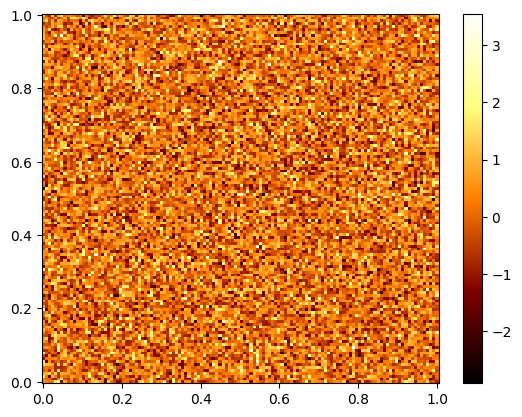

{'Image header size': '3037', 'Angle': '0', 'Set Point': '-9 V', 'Signal Gain': '1', 'Topography Bias': '0 mV', 'X Amplitude': '1 nm', 'X Offset': '0 nm', 'X-Frequency': '58.594 Hz', 'XY Gain': '0.0588235', 'Y Amplitude': '1 nm', 'Y Offset': '-451.813 nm', 'Z Gain': '10', 'Z Offset': '0 nm', 'Amplitude': '1e-006 V', 'Bandwidth': '445.626', 'Filter Out': '8079 Hz', 'Frq. Scan Sensitivity': '0.024 kHz/V', 'Gain in': '100', 'Gain out X': '2', 'Gain out Y': '2', 'Phase': '52.9998 Deg', 'Quality factor (Q)': '171.177', 'Resonance frequency': '72293.6 Hz', 'Input channel': 'Amplitude', 'Integral': '2.5', 'Proportional': '10', 'Tilt X': '0 nm/nm', 'Tilt Y': '0 nm/nm', 'Acquisition channel': 'Amplitude', 'Acquisition primary channel': 'Channel 15', 'Channel is inverted': 'No', 'Conversion Factor 00': '10 nm', 'Conversion Offset 00': '0 nm', 'Force constant': '165.73 N/m', 'Head type': 'AFM', 'Image Data Type': 'short', 'Number of columns': '128', 'Number of rows': '128', 'Round percent': '10',

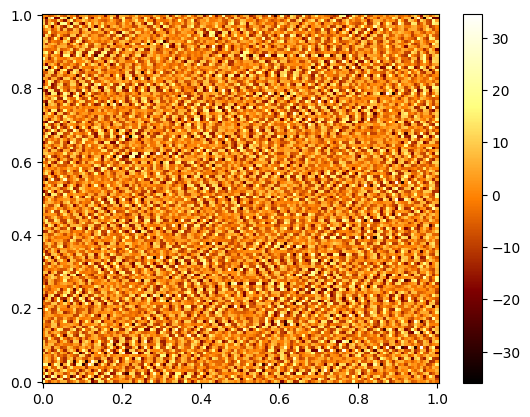

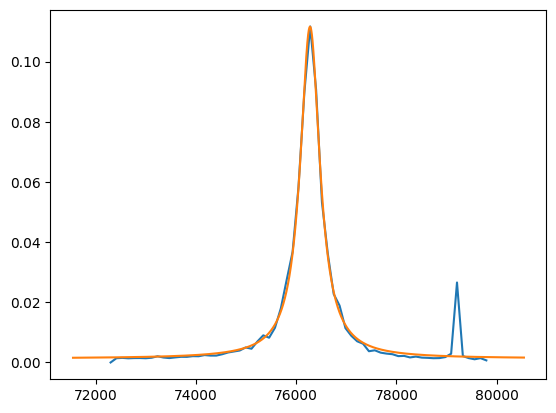

{'offset': 0.0012934139192533319, 'resonance freq': 76274.15433510602, 'fwhm': 473.8767061692985, 'area': 82.11451304229297, 'Q factor': 160.9578047245397}


In [2]:
files = ['data/20240202_laser_off_128pts_58lps_0002.f.dy.ch15', 
         'data/20240202_laser_on_128pts_58lps_0003.f.dy.ch15']
data_dict = {}
rms_min = np.inf
for file in files:
    data_dict[file] = {}
    data_dict[file]['Frequency'], data_dict[file]['PSD'], data_dict[file]['Z rms'] = get_psd(file)
    if data_dict[file]['Z rms'] < rms_min:
        rms_min = data_dict[file]['Z rms']
        off_file = file

on_file = [n for n in files if n != off_file][0]
data_dict[off_file]['Label'] = 'Laser ON'
data_dict[on_file]['Label'] = 'Laser OFF'

#plot data images
# for file in files:
#     plt.plot(data_dict[file]['Frequency'], data_dict[file]['PSD'], label = data_dict[file]['PSD'])
# plt.show()
    

#z_pow = 2*(z_fftx_avg[64:]**2)/(15000*128)
#freq_drive = float(head_data['Resonance frequency'].split(' ')[0])
#freq_array_real = freq_array_shift[64:] + freq_drive
freq_final = data_dict[on_file]['Frequency']
psd_final = data_dict[on_file]['PSD'] - data_dict[off_file]['PSD']
plt.plot(freq_final, psd_final)
#plt.show()

#guess = [0, 76000, 2000, 100000]
y_guess = psd_final.min()
f_guess = freq_final[psd_final.argmax()]
w_guess = 2*np.abs(freq_final[(np.abs(psd_final - psd_final.max()/2)).argmin()]-f_guess)
A_guess = np.pi*w_guess*psd_final.max()/2
guess = [y_guess, f_guess, w_guess, A_guess] #y0,f0,w,A
#fit
popt, pcov = curve_fit(lorentzian, freq_final,psd_final,
                    p0=guess, bounds=(0,np.inf))
#print(np.linalg.cond(pcov))
params = ['offset','resonance freq', 'fwhm', 'area']
fit_dict = dict(zip(params, popt))
fit_dict['Q factor'] = fit_dict['resonance freq']/fit_dict['fwhm']

#plot fit
f_min, f_max = freq_final.min(), freq_final.max()
f_ext = 0.1*(f_max-f_min)
freq_fit_range = np.linspace(f_min-f_ext, f_max+f_ext, 100000)
plt.plot(freq_fit_range,lorentzian(freq_fit_range, *popt))
plt.show()

print(fit_dict)

In [37]:
# Q = head_data['Quality factor (Q)']
k_cant = 2 # N/m
T = 300 #K
kb = 1.380649e-23 #J/K
V_rms = np.sqrt(fit_dict['area'])
corr_fac = 4/3 #Butt-Jaschke correction for thermal noise
sens = np.sqrt(corr_fac*kb*T/k_cant)/V_rms/1e-9 #nm/V 
print(V_rms, sens)
print(np.sqrt(data_dict[on_file]['Z rms']**2 - data_dict[off_file]['Z rms']**2))
# z = im_data['Z']
# print(np.sqrt(z.dot(z)/z.size))

9.061705857193388 0.005798914136715741
9.421556156513725


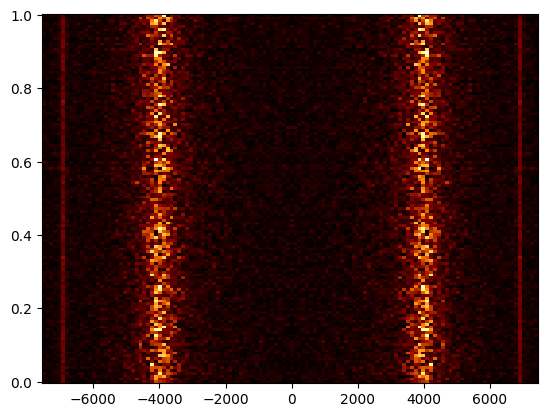

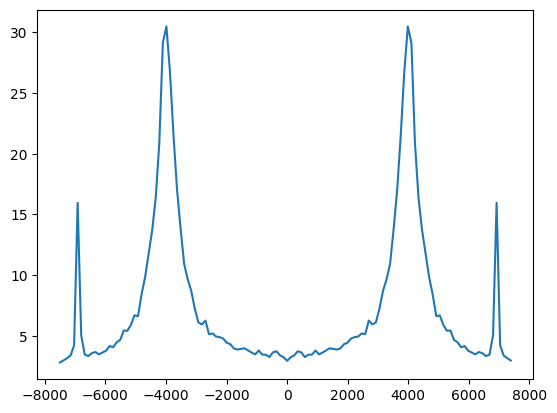

In [6]:
# #1D Fourier Transform of image and average along Y axis.
# z_fftx = np.abs(np.fft.fft(zz))
# z_fftx_shift = np.fft.fftshift(z_fftx)
# z_fftx_avg = np.average(z_fftx_shift, axis=0)

# num_pts = len(z_fftx_avg)
# sample_rate = 2*num_pts*float(head_data['X-Frequency'].split(' ')[0])
# freq_array = np.fft.fftfreq(len(z_fftx_avg), 1 / sample_rate)
# freq_array_shift = np.fft.fftshift(freq_array)
# ff, _ = np.meshgrid(freq_array_shift, freq_array_shift)
# plt.pcolormesh(ff, yy, z_fftx_shift, cmap='afmhot')
# plt.show()
# plt.plot(freq_array_shift, z_fftx_avg)
# plt.show()